references:

*   https://coin-or.github.io/pulp/CaseStudies/a_two_stage_production_planning_problem.html
*   to read for fun: https://www.quora.com/Why-do-so-many-statisticians-not-want-to-become-data-scientists-Why-are-they-not-interested-in-Big-Data/answer/Adrian-Olszewski-1?ch=10&oid=39581408&share=8169356a&srid=MByz&target_type=answer



In [ ]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
data=pd.read_excel('/content/stochastic_data.xlsx',sheet_name='d10')

In [ ]:
data

,production_capacity_P1,production_capacity_P2,storage_capacity,initial_inventory_P1,initial_inventory_P2,holding_cost,final_value_P1,final_value_P2,demand_P1,demand_P2,loading_pace_V1,loading_pace_V2,total_products,penalty_cost_V1,penalty_cost_V2
0,400,400,800.0,0.0,0.0,100.0,41.0,41.0,300.0,300.0,300.0,300.0,2.0,20.0,20.0
1,400,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,400,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,400,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,400,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,400,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,400,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,400,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,400,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,400,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#parameters
nbr_of_periods=int(len(data.production_capacity_P1)) #T
nbr_of_products=int(data.total_products[0])
nbr_of_vessels=int(data.total_products[0])#1 vessel = 1 product
#nbr_of_PLs=1

#planning horizon
periods=range(nbr_of_periods)

#nbr of inventory periods=nbr of production periods+1
inventory_periods=range(nbr_of_periods+1)


#production capacity
products=range(nbr_of_products)
production_capacity_P1=list(data.production_capacity_P1)
production_capacity_P2=list(data.production_capacity_P2)
production_capacity=[production_capacity_P1,production_capacity_P2]

#storage
storage_capacity_PL=data.storage_capacity[0]
initial_inventory=[data.initial_inventory_P1[0], data.initial_inventory_P2[0]]
holding_cost=data.holding_cost[0]
final_unit_value_remaining_inventory=[data.final_value_P1[0],data.final_value_P2[0]]





In [ ]:
#generate time arrival uniform distribution sample
#minimum vessel arrival time???????????????? is 0 possible????????
def generate_uniform_ETA(number_of_scenarios,number_of_periods,number_of_vessels,min_ETA):
  return np.random.uniform(low=min_ETA,high=number_of_periods,size=(number_of_scenarios,number_of_vessels))



In [ ]:
#example: 10 scenarios, 50 time periods, 5 vessels, min_ETA=1
generate_uniform_ETA(10,50,5,1)

array([[28.58005784, 23.7831613 , 26.35744349, 25.37888217, 23.67964877],
       [28.37815612, 18.78077033, 44.39607403, 42.77305848,  7.5915763 ],
       [30.58504008, 48.88621981, 18.30809919, 21.69790924, 18.29588719],
       [ 7.55317138, 44.35176349, 40.67727921, 39.25128104,  4.11903731],
       [42.7857418 , 31.6293181 , 39.14285508, 47.59171765, 49.36982377],
       [ 3.88339007,  1.55744928, 30.25219254, 24.62273797, 28.61958145],
       [19.19528814, 40.42612601, 48.43828305, 30.50810663,  7.66956565],
       [29.12175344, 34.58335702, 29.38055597,  2.53422681, 34.22087681],
       [ 3.92425888,  8.92709812,  8.81404977, 10.03309858, 30.87347471],
       [42.4741834 , 15.09214605, 34.20492442, 12.58040681, 19.30018381]])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


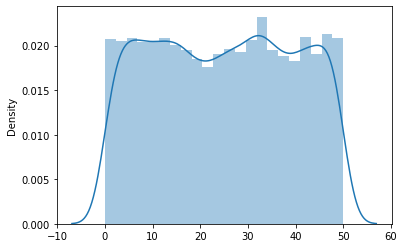

In [ ]:
plt.figure()
sns.distplot(generate_uniform_ETA(100,50,100,0))#100 scenarios, 50 time periods, 1000 vessels (just an example)
plt.show()
#the density function of uniform probability distribution U([a,b]) is 1/(b-a)=1/(50-0)
#when number of vessels tends to infinity the data distribution converges to the theoretic U([0,50])


we suppose that scenarios are equiprobable, so p_s=1/number_of_scenerios

In [ ]:
number_of_scenarios=5
scenarios=list(range(number_of_scenarios))
number_of_periods=10
number_of_vessels=2
vessels=range(number_of_vessels)
minimum_ETA=1

In [ ]:
ETA=generate_uniform_ETA(number_of_scenarios,number_of_periods,number_of_vessels,minimum_ETA)#replace nbr_of_periods by max_eta!!!!!!
ETA.shape

(5, 2)

In [ ]:
ETA

array([[5.77823476, 9.21107099],
       [9.95766835, 8.1990265 ],
       [3.35068863, 2.47397795],
       [8.04620469, 1.68131117],
       [5.09995543, 3.35010185]])

In [ ]:
print(int(ETA[0][0]),int(ETA[0][1]) )

5 9


so the vessel can start loading at int(ETA)+1

In [ ]:

penalty_cost=[data.penalty_cost_V1[0],data.penalty_cost_V2[0]]
nominal_loading_pace=[data.loading_pace_V1[0], data.loading_pace_V2[0]]
demand=[[data.demand_P1[0], 0],[0, data.demand_P2[0]]]

In [ ]:
# get the start time
st = time.time()
#define our optimisation problem

prob = LpProblem("Fertilizers_production_planning", LpMinimize)

In [ ]:
# Decision Variables
#production_vars = pulp.LpVariable.dicts(
    #"production", (scenarios, products), lowBound=0, cat="Continuous"
#)
U = LpVariable.dicts("U", (scenarios,vessels,periods), cat="Binary")
Z = LpVariable.dicts("Z", (scenarios,vessels,periods), cat="Binary")
Q = LpVariable.dicts("Q", (scenarios,products,vessels,periods),lowBound=0, cat="Continuous")#
#X = LpVariable.dicts("X", (vessels), cat="Binary")

I = LpVariable.dicts("I", (scenarios,products,inventory_periods),lowBound=0, cat="Continuous")

#do not depend on scenario
P = LpVariable.dicts("P", (products,periods),lowBound=0, cat="Continuous")
#J = LpVariable.dicts("J", (raw_materials,inventory_periods),lowBound=0, cat="Continuous")
Y = LpVariable.dicts("Y", (products,periods), cat="Binary")
#W = LpVariable.dicts("W", (products,products,periods), cat="Binary")

In [ ]:
#make clear the formulas!!!!!

# Objective Function
prob += ( lpSum([lpSum( [1/number_of_scenarios*(penalty_cost[k]*max(t-ETA[s][k],0)+lpSum([holding_cost*demand[i][k]*max(ETA[s][k]-t,0)
                              for i in products])) for s in scenarios] )*U[s][k][t]
                  for k in vessels for t in periods for s in scenarios] )#finished with penalty loss
        +lpSum( [(lpSum([holding_cost*I[s][i][t] for t in range(1,nbr_of_periods+1)])-
                  (final_unit_value_remaining_inventory[i]*I[s][i][nbr_of_periods])) for i in products for s in scenarios] )
        , "Total penalty cost" )

#prob += (lpSum([penalty_cost[i][j]*Z[i][j] for i in vessels for j in periods])
 #       +lpSum( [(holding_cost*I[i][t]) for t in periods for i in products] ), "Total penalty cost")



#constraints

#1
for i in products:
  for t in range(1,number_of_periods+1):
    for s in scenarios:
      prob+=(I[s][i][t]==I[s][i][t-1]+P[i][t-1]-lpSum([Q[s][i][k][t-1] for k in vessels]))


#3
for t in inventory_periods:
  for s in scenarios:
    prob+=(lpSum([I[s][i][t] for i in products])<=storage_capacity_PL)


#4
#for t in range(1,nbr_of_periods+1):
 # for r in raw_materials:
  #  prob+=J[r][t]==J[r][t-1]+replinishment_RM[r][t]-lpSum([consumption_RM[r][i]*P[i][t-1] for i in products])

#5
#for t in inventory_periods:
 # for r in raw_materials:
  #  prob+=J[r][t]<=storage_capacity_RM[r]

#6: only one single product can be produced at time t on one production line
for t in periods:
  prob+=lpSum([Y[i][t] for i in products])<=1

#7
for i in products:
  for t in periods:
    prob+=P[i][t]<=production_capacity[i][t]*Y[i][t]

#8
#for i in products:
 # for t in periods:
  #  prob+=P[i][t]<=production_capacity[i][t]-lpSum([changeover_amount_of_capacity[i][j]*W[i][j][t] for j in products])

#9
#for i in products:
 # for j in products:
  #  for t in range(1,nbr_of_periods):
   #   prob+=W[i][j][t]>=Y[i][t-1]+Y[j][t]-1

#10
#for i in products:
 # for j in products:
  #  for t in range(1,nbr_of_periods):
   #   prob+=W[i][j][t]<=Y[i][t-1]

#11
#for i in products:
 # for j in products:
  #  for t in periods:
   #   prob+=W[i][j][t]<=Y[j][t]


#12: the loaded quantity is constrained by the loading pace
for i in products:
  for k in vessels:
    for t in periods:
      for s in scenarios:
        prob+=Q[s][i][k][t]<=nominal_loading_pace[k]*Z[s][k][t]



#13: ensures that loaded quantity of product i=demand of i
for k in vessels:
  for i in products:
    for s in scenarios:
      prob+=lpSum([Q[s][i][k][t] for t in periods])==demand[i][k]


#14: after i removed this constraint the problem of loading interruption was resolved
#for i in products:
 # for k in vessels:
  #  for t in periods:
   #   prob+=Q[i][k][t]<=nominal_loading_pace[k]*X[k]#because vessel 0 load P0, V1 loads P1,...(one product = one vessel)

#15
#for k in vessels:
 # prob+=(X[k]==1)

#16: no vessel can load before arrival time
#depends on s??????????????????????????????????????????
#for k in vessels:
 # for t in range(ETA[k]):
  #  prob+=Z[k][t]==0
   # prob+=lpSum([Q[i][k][t] for i in products])==0

#17: every vessel starts loading at ETA+1
#for k in vessels:
 # prob+=Z[k][ETA[k]]==1

#18: initial product inventory
for i in products:
  for s in scenarios:
    prob+=I[s][i][0]==initial_inventory[i]



#19: initial raw material inventory
#for r in raw_materials:
 # prob+=J[r][0]==replinishment_RM[r][0]

#20: constraint added to prevent W_iit=1
#for i in products:
 # for t in periods:
  #  prob+=W[i][i][t]==0


#23
for k in vessels:
  for t in periods:
    for s in scenarios:
      prob+=U[s][k][t]<=Z[s][k][t]



#24
for k in vessels:
  for s in scenarios:
    prob+=lpSum([U[s][k][t] for t in periods])==1


#25
for k in vessels:
  for t in range(1,number_of_periods):
    for s in scenarios:
      prob+=(Z[s][k][t]-Z[s][k][t-1]<=U[s][k][t])



#26 in overleaf
for k in vessels:
  for t in range(1,nbr_of_periods):
    for s in scenarios:
      prob+=(Z[s][k][t]<=lpSum([U[s][k][n] for n in range(t+1)]))



#27 commented in overleaf
for k in vessels:
  for t in range(1,nbr_of_periods):
    for s in scenarios:
      prob+=(lpSum([Z[s][k][n] for n in range(t)])+U[s][k][t]<=1)




In [ ]:
status = prob.solve()
print(LpStatus[status])


Optimal


In [ ]:
# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.5083715915679932 seconds


In [ ]:
for v in prob.variables():
  print(v.name, "=", v.varValue)

I_0_0_0 = 0.0
I_0_0_1 = 0.0
I_0_0_10 = 0.0
I_0_0_2 = 0.0
I_0_0_3 = 0.0
I_0_0_4 = 0.0
I_0_0_5 = 0.0
I_0_0_6 = 0.0
I_0_0_7 = 0.0
I_0_0_8 = 0.0
I_0_0_9 = 0.0
I_0_1_0 = 0.0
I_0_1_1 = 0.0
I_0_1_10 = 0.0
I_0_1_2 = 0.0
I_0_1_3 = 0.0
I_0_1_4 = 0.0
I_0_1_5 = 0.0
I_0_1_6 = 0.0
I_0_1_7 = 0.0
I_0_1_8 = 0.0
I_0_1_9 = 0.0
I_1_0_0 = 0.0
I_1_0_1 = 0.0
I_1_0_10 = 0.0
I_1_0_2 = 0.0
I_1_0_3 = 0.0
I_1_0_4 = 0.0
I_1_0_5 = 0.0
I_1_0_6 = 0.0
I_1_0_7 = 0.0
I_1_0_8 = 0.0
I_1_0_9 = 0.0
I_1_1_0 = 0.0
I_1_1_1 = 0.0
I_1_1_10 = 0.0
I_1_1_2 = 0.0
I_1_1_3 = 0.0
I_1_1_4 = 0.0
I_1_1_5 = 0.0
I_1_1_6 = 0.0
I_1_1_7 = 0.0
I_1_1_8 = 0.0
I_1_1_9 = 0.0
I_2_0_0 = 0.0
I_2_0_1 = 0.0
I_2_0_10 = 0.0
I_2_0_2 = 0.0
I_2_0_3 = 0.0
I_2_0_4 = 0.0
I_2_0_5 = 0.0
I_2_0_6 = 0.0
I_2_0_7 = 0.0
I_2_0_8 = 0.0
I_2_0_9 = 0.0
I_2_1_0 = 0.0
I_2_1_1 = 0.0
I_2_1_10 = 0.0
I_2_1_2 = 0.0
I_2_1_3 = 0.0
I_2_1_4 = 0.0
I_2_1_5 = 0.0
I_2_1_6 = 0.0
I_2_1_7 = 0.0
I_2_1_8 = 0.0
I_2_1_9 = 0.0
I_3_0_0 = 0.0
I_3_0_1 = 0.0
I_3_0_10 = 0.0
I_3_0_2 = 0.0
I_3_0_3 = 0.0

In [ ]:
print("Total Cost  = ", value(prob.objective))

Total Cost  =  67049.65485373682


In [ ]:
prob.writeLP("fertilizers_prod_planning.lp")

[I_0_0_0,
 I_0_0_1,
 I_0_0_10,
 I_0_0_2,
 I_0_0_3,
 I_0_0_4,
 I_0_0_5,
 I_0_0_6,
 I_0_0_7,
 I_0_0_8,
 I_0_0_9,
 I_0_1_0,
 I_0_1_1,
 I_0_1_10,
 I_0_1_2,
 I_0_1_3,
 I_0_1_4,
 I_0_1_5,
 I_0_1_6,
 I_0_1_7,
 I_0_1_8,
 I_0_1_9,
 I_1_0_0,
 I_1_0_1,
 I_1_0_10,
 I_1_0_2,
 I_1_0_3,
 I_1_0_4,
 I_1_0_5,
 I_1_0_6,
 I_1_0_7,
 I_1_0_8,
 I_1_0_9,
 I_1_1_0,
 I_1_1_1,
 I_1_1_10,
 I_1_1_2,
 I_1_1_3,
 I_1_1_4,
 I_1_1_5,
 I_1_1_6,
 I_1_1_7,
 I_1_1_8,
 I_1_1_9,
 I_2_0_0,
 I_2_0_1,
 I_2_0_10,
 I_2_0_2,
 I_2_0_3,
 I_2_0_4,
 I_2_0_5,
 I_2_0_6,
 I_2_0_7,
 I_2_0_8,
 I_2_0_9,
 I_2_1_0,
 I_2_1_1,
 I_2_1_10,
 I_2_1_2,
 I_2_1_3,
 I_2_1_4,
 I_2_1_5,
 I_2_1_6,
 I_2_1_7,
 I_2_1_8,
 I_2_1_9,
 I_3_0_0,
 I_3_0_1,
 I_3_0_10,
 I_3_0_2,
 I_3_0_3,
 I_3_0_4,
 I_3_0_5,
 I_3_0_6,
 I_3_0_7,
 I_3_0_8,
 I_3_0_9,
 I_3_1_0,
 I_3_1_1,
 I_3_1_10,
 I_3_1_2,
 I_3_1_3,
 I_3_1_4,
 I_3_1_5,
 I_3_1_6,
 I_3_1_7,
 I_3_1_8,
 I_3_1_9,
 I_4_0_0,
 I_4_0_1,
 I_4_0_10,
 I_4_0_2,
 I_4_0_3,
 I_4_0_4,
 I_4_0_5,
 I_4_0_6,
 I_4_0_7,
 I_4_0_8,
 I_4_0_9,
 

In [ ]:
#ask about the way to compare different versions and how to show the benefit of stochastic optimisation
#correct Z,U